In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure GPU memory growth to avoid OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


In [2]:
train_dir = "../data/expressions/train" 
test_dir = "../data/expressions/test"   

In [3]:
img_size = 48 

In [4]:
# Enhanced data augmentation with more techniques
# Using more aggressive augmentation for better generalization
train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest',
    validation_split=0.2
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
# Calculate class weights for handling imbalance
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get class indices from train_generator
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Create class weights based on actual class distribution
# Using the class counts we found earlier
class_counts = {
    'angry': 3995,
    'disgust': 436, 
    'fear': 4097,
    'happy': 7215,
    'neutral': 4965,
    'sad': 4830,
    'surprise': 3171
}

# Create y array for compute_class_weight
y_array = []
for class_name, count in class_counts.items():
    y_array.extend([class_indices[class_name]] * count)

y_array = np.array(y_array)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_array),
    y=y_array
)

# Create proper dictionary with integer keys
class_weights_dict = {i: float(weight) for i, weight in enumerate(class_weights)}

print("Class weights for balancing:")
for i, class_name in enumerate(class_names):
    weight = class_weights_dict[i]
    print(f"  {class_name}: {weight:.4f}")

print(f"\nClass weights dictionary: {class_weights_dict}")

# Create label dictionary for emotion prediction
label_dict = {i: class_name for i, class_name in enumerate(class_names)}
print(f"\nLabel dictionary: {label_dict}")

Class weights for balancing:
  angry: 1.0266
  disgust: 9.4066
  fear: 1.0010
  happy: 0.5684
  neutral: 0.8260
  sad: 0.8491
  surprise: 1.2934

Class weights dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}

Label dictionary: {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [7]:
# Improved model architecture optimized for grayscale emotion recognition
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, Add, Multiply
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Custom CNN architecture optimized for 48x48 grayscale images
# Using a deeper, more sophisticated architecture with residual connections
def create_emotion_model(input_shape=(48, 48, 1), num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Initial feature extraction with multiple scales
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', 
                               kernel_regularizer=l2(1e-4))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Block 1
    residual = x
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Residual connection
    if residual.shape[-1] != x.shape[-1]:
        residual = tf.keras.layers.Conv2D(128, (1, 1), padding='same')(residual)
    x = Add()([x, residual])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    
    # Block 2 with attention mechanism
    residual = x
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # Channel attention (Squeeze-and-Excitation)
    # Global average pooling for channel attention
    gap = tf.keras.layers.GlobalAveragePooling2D()(x)
    gap = tf.keras.layers.Dense(256//8, activation='relu')(gap)
    gap = tf.keras.layers.Dense(256, activation='sigmoid')(gap)
    gap = tf.keras.layers.Reshape((1, 1, 256))(gap)
    x = Multiply()([x, gap])
    # Residual connection
    if residual.shape[-1] != x.shape[-1]:
        residual = tf.keras.layers.Conv2D(256, (1, 1), padding='same')(residual)
    x = Add()([x, residual])
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    # Block 3
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu',
                               kernel_regularizer=l2(1e-4))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Global pooling - using both average and max pooling
    gap = GlobalAveragePooling2D()(x)
    gmp = GlobalMaxPooling2D()(x)
    x = Concatenate()([gap, gmp])
    
    # Dense layers with regularization
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    
    # Output layer
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = create_emotion_model(input_shape=(48, 48, 1), num_classes=7)

# Compile with improved optimizer and learning rate
# Using lower initial learning rate for more stable training
model.compile(
    optimizer=Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'top_k_categorical_accuracy']
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 48, 48,    │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 48, 48,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 48, 48,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 24, 24,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 24, 24,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │      8,320 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 12, 12,    │          0 │ add[0][0]         │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 12,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ conv2d_5[0][0]  

 Total params: 5,410,919 (20.64 MB)

 Trainable params: 5,405,543 (20.62 MB)

 Non-trainable params: 5,376 (21.00 KB)

In [8]:
# Enhanced training parameters and callbacks
epochs = 50
batch_size = 32  # Smaller batch size for better gradient estimates

# Custom learning rate scheduler
def cosine_annealing_schedule(epoch, lr):
    """Cosine annealing with restarts"""
    epochs_per_cycle = 10
    cycle = epoch // epochs_per_cycle
    x = epoch % epochs_per_cycle
    lr_min = 1e-6
    lr_max = 0.0005
    lr = lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(np.pi * x / epochs_per_cycle))
    return lr

# Enhanced callbacks for better training
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,  # Increased patience
        restore_best_weights=True,
        verbose=1,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,  # More aggressive reduction
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),
    ModelCheckpoint(
        '../model/best_expression_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1,
        mode='max',
        save_weights_only=False
    ),
    tf.keras.callbacks.LearningRateScheduler(cosine_annealing_schedule, verbose=0)
]

In [9]:
# Train with class weights and callbacks
history = model.fit(
    x=train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.1492 - loss: 3.8931 - top_k_categorical_accuracy: 0.7316
Epoch 1: val_accuracy improved from None to 0.01536, saving model to ../model/best_expression_model.keras

Epoch 1: finished saving model to ../model/best_expression_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 184s 502ms/step - accuracy: 0.1515 - loss: 3.6431 - top_k_categorical_accuracy: 0.7384 - val_accuracy: 0.0154 - val_loss: 3.4862 - val_top_k_categorical_accuracy: 0.7619 - learning_rate: 5.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.1550 - loss: 3.2701 - top_k_categorical_accuracy: 0.7507
Epoch 2: val_accuracy improved from 0.01536 to 0.16760, saving model to ../model/best_expression_model.keras

Epoch 2: finished saving model to ../model/best_expression_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 176s 489ms/step - accuracy: 0.1532 - loss: 3.2102 - top_k_categorical_accuracy: 0.7519 - val_accuracy: 0.1676 - val_loss: 2.9077 - val_

In [10]:
# Save the improved model in modern Keras format
model.save('../model/improved_expression_model.keras')
print("Model saved successfully!")

Model saved successfully!


In [11]:
# Continue training with the same model (no fine-tuning needed for custom architecture)
# If you want to continue training, uncomment below:
# fine_tune_epochs = 20
# total_epochs = len(history.history['accuracy']) + fine_tune_epochs
# 
# history_fine = model.fit(
#     x=train_generator,
#     epochs=total_epochs,
#     initial_epoch=len(history.history['accuracy']),
#     validation_data=validation_generator,
#     class_weight=class_weights_dict,
#     callbacks=callbacks,
#     verbose=1
# )

print("Initial training completed. Model is ready for evaluation.")

Initial training completed. Model is ready for evaluation.


In [12]:
# Optional: Additional training phase with even lower learning rate
# Uncomment if you want to fine-tune further
# model.compile(
#     optimizer=Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999),
#     loss='categorical_crossentropy',
#     metrics=['accuracy', 'top_k_categorical_accuracy']
# )
# 
# fine_tune_callbacks = [
#     EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True, verbose=1),
#     ModelCheckpoint('../model/best_expression_model.keras', monitor='val_accuracy', 
#                     save_best_only=True, verbose=1)
# ]
# 
# history_fine = model.fit(
#     x=train_generator,
#     epochs=epochs + 10,
#     initial_epoch=len(history.history['accuracy']),
#     validation_data=validation_generator,
#     class_weight=class_weights_dict,
#     callbacks=fine_tune_callbacks,
#     verbose=1
# )

print("Training setup complete. Run the training cell to start training.")

Training setup complete. Run the training cell to start training.


Generating predictions for evaluation...
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step
Predictions generated. Shape: (1432,)

PER-CLASS PERFORMANCE METRICS
 Emotion  Precision   Recall  F1-Score  Support
   angry   0.154286 0.141361  0.147541      191
 disgust   0.000000 0.000000  0.000000       22
    fear   0.157895 0.073529  0.100334      204
   happy   0.274627 0.259887  0.267054      354
 neutral   0.197581 0.199187  0.198381      246
     sad   0.191436 0.305221  0.235294      249
surprise   0.126667 0.114458  0.120253      166


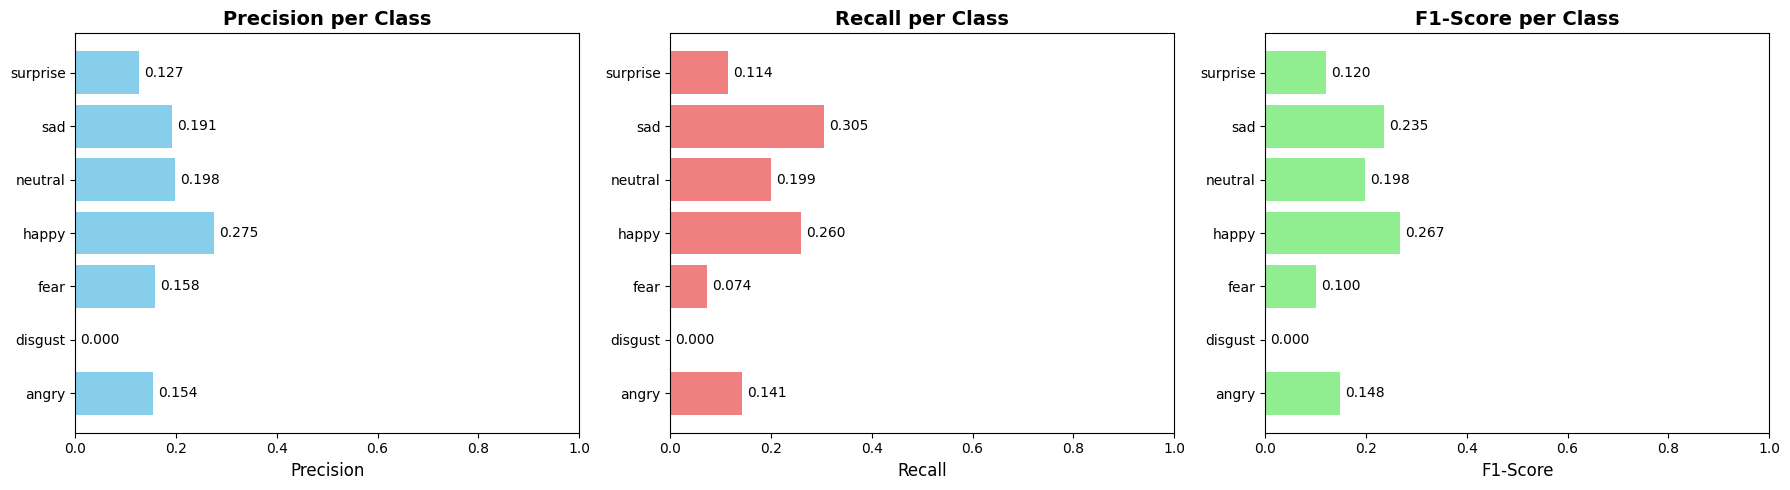


CLASSES NEEDING IMPROVEMENT (F1-Score < 0.6)
 Emotion  F1-Score  Support
   angry  0.147541      191
 disgust  0.000000       22
    fear  0.100334      204
   happy  0.267054      354
 neutral  0.198381      246
     sad  0.235294      249
surprise  0.120253      166


In [ ]:
# Per-class performance analysis
from sklearn.metrics import precision_recall_fscore_support

# Generate predictions if not already done
try:
    # Check if variables exist by trying to access them
    _ = y_true
    _ = y_pred_classes
    print("Using existing predictions...")
except NameError:
    print("Generating predictions for evaluation...")
    y_pred = model.predict(validation_generator, verbose=1)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = validation_generator.classes
    print(f"Predictions generated. Shape: {y_pred_classes.shape}")

# Get class labels if not already defined
try:
    _ = class_labels
except NameError:
    class_labels = list(validation_generator.class_indices.keys())

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred_classes, average=None, zero_division=0
)

# Create a detailed performance DataFrame
performance_df = pd.DataFrame({
    'Emotion': class_labels,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\n" + "="*70)
print("PER-CLASS PERFORMANCE METRICS")
print("="*70)
print(performance_df.to_string(index=False))
print("="*70)

# Visualize per-class performance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Precision
axes[0].barh(class_labels, precision, color='skyblue')
axes[0].set_xlabel('Precision', fontsize=12)
axes[0].set_title('Precision per Class', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
for i, v in enumerate(precision):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Recall
axes[1].barh(class_labels, recall, color='lightcoral')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_title('Recall per Class', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
for i, v in enumerate(recall):
    axes[1].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1-Score
axes[2].barh(class_labels, f1, color='lightgreen')
axes[2].set_xlabel('F1-Score', fontsize=12)
axes[2].set_title('F1-Score per Class', fontsize=14, fontweight='bold')
axes[2].set_xlim([0, 1])
for i, v in enumerate(f1):
    axes[2].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

# Identify classes that need improvement
print("\n" + "="*70)
print("CLASSES NEEDING IMPROVEMENT (F1-Score < 0.6)")
print("="*70)
low_performance = performance_df[performance_df['F1-Score'] < 0.6]
if len(low_performance) > 0:
    print(low_performance[['Emotion', 'F1-Score', 'Support']].to_string(index=False))
else:
    print("All classes performing well!")
print("="*70)


Final train accuracy: 62.26%
Final validation accuracy: 66.20%
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.14      0.13      0.13       191
     disgust       0.00      0.00      0.00        22
        fear       0.14      0.06      0.09       204
       happy       0.23      0.22      0.22       354
     neutral       0.17      0.17      0.17       246
         sad       0.18      0.29      0.22       249
    surprise       0.09      0.08      0.09       166

    accuracy                           0.17      1432
   macro avg       0.14      0.14      0.13      1432
weighted avg       0.17      0.17      0.16      1432



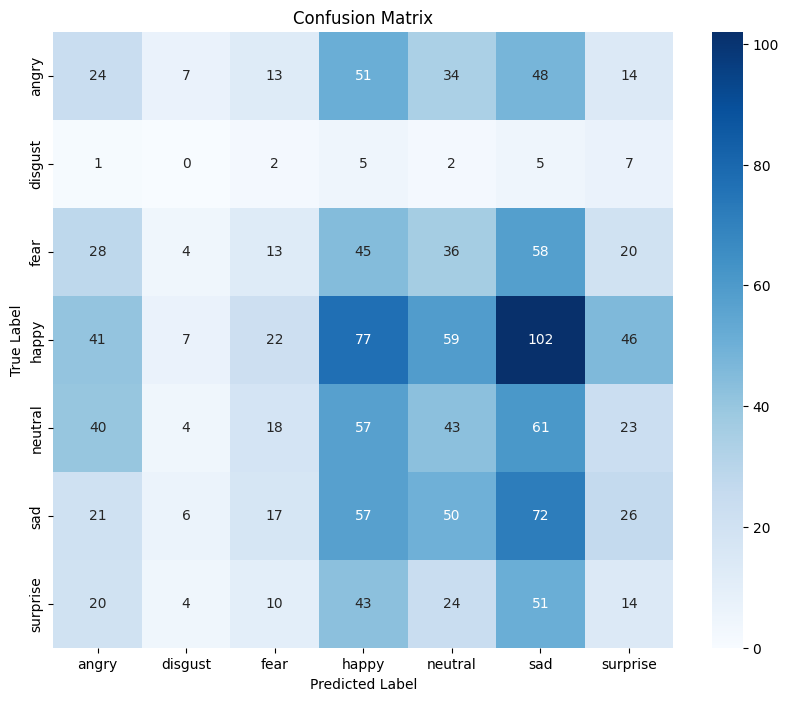

In [17]:
# Comprehensive evaluation
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Evaluate on training and validation sets
# Note: model.evaluate() returns [loss, accuracy, top_k_accuracy] when multiple metrics are used
train_results = model.evaluate(train_generator, verbose=0)
test_results = model.evaluate(validation_generator, verbose=0)

# Unpack results (first is loss, second is accuracy)
train_loss, train_acc = train_results[0], train_results[1]
test_loss, test_acc = test_results[0], test_results[1]

print(f"Final train accuracy: {train_acc*100:.2f}%")
print(f"Final validation accuracy: {test_acc*100:.2f}%")

# Generate predictions for detailed analysis
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

# Classification report
class_labels = list(validation_generator.class_indices.keys())
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

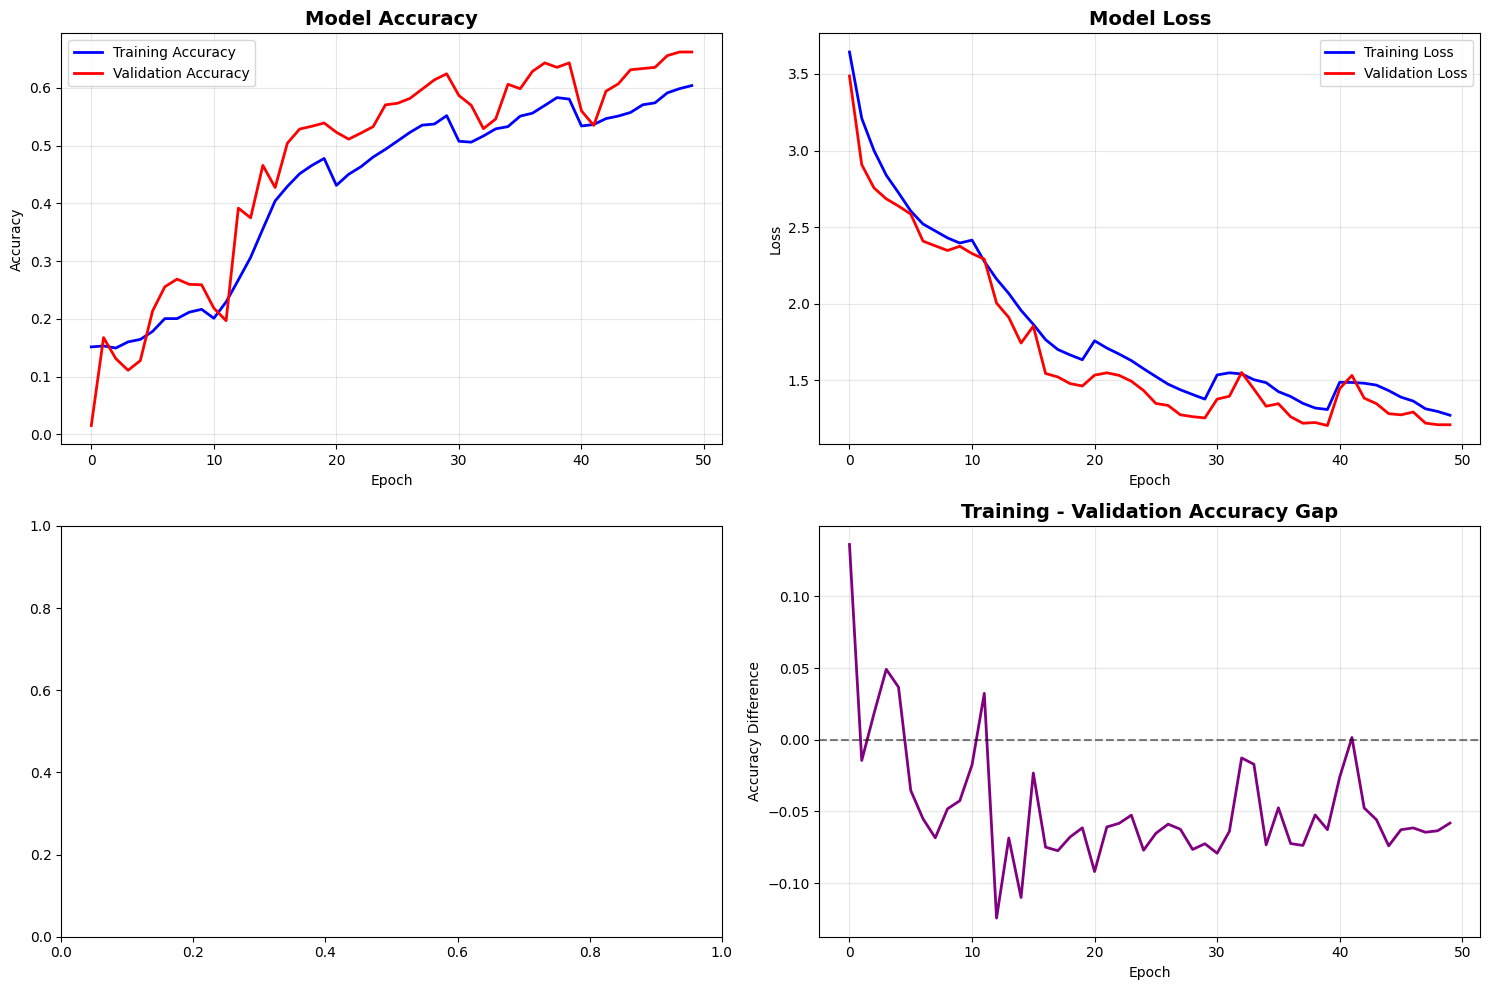


Training Summary
Final Training Accuracy: 60.39%
Final Validation Accuracy: 66.20%
Best Validation Accuracy: 66.20%
Final Training Loss: 1.2728
Final Validation Loss: 1.2107
Best Validation Loss: 1.2055


In [18]:
# Enhanced visualization of training progress
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2, color='blue')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, color='red')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='red')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot learning rate if available
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, color='green')
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

# Accuracy difference (overfitting indicator)
if len(history.history['accuracy']) == len(history.history['val_accuracy']):
    acc_diff = [a - v for a, v in zip(history.history['accuracy'], history.history['val_accuracy'])]
    axes[1, 1].plot(acc_diff, linewidth=2, color='purple')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Training - Validation Accuracy Gap', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Difference')
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print improvement summary
print(f"\n{'='*60}")
print(f"Training Summary")
print(f"{'='*60}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Best Validation Loss: {min(history.history['val_loss']):.4f}")
print(f"{'='*60}")

In [19]:
# Example: Load and predict on an image
# Replace 'path_to_image.jpg' with your actual image path
# img_path = 'path_to_image.jpg'
# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# img = cv2.resize(img, (48, 48))
# img = np.expand_dims(img, axis=0)  # makes image shape (1,48,48)
# img = img.reshape(1, 48, 48, 1)
# result = model.predict(img, verbose=0)
# result = list(result[0])
# print(f"Prediction probabilities: {result}")
# print(f"Predicted emotion: {label_dict[np.argmax(result)]}")

# For demonstration, using a random image (uncomment above for actual prediction)
print("Note: Load an image using cv2.imread() and preprocess it before predicting")
print("Example code is commented above")

Note: Load an image using cv2.imread() and preprocess it before predicting
Example code is commented above


In [20]:
# Example usage (uncomment when you have a prediction result):
# img_index = np.argmax(result)  # Get index of maximum probability
# predicted_emotion = label_dict[img_index]
# print(f"Predicted emotion: {predicted_emotion}")
# print(f"Confidence: {result[img_index]:.4f}")

# If you have an image loaded and predicted, use:
# img_index = np.argmax(result)
# print(f"Predicted emotion: {label_dict[img_index]}")
# plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
# plt.title(f"Predicted: {label_dict[img_index]}")
# plt.axis('off')
# plt.show()

print("Note: Uncomment the code above when you have a prediction result")

Note: Uncomment the code above when you have a prediction result


In [22]:
# Evaluate model (returns [loss, accuracy, top_k_accuracy] when multiple metrics are used)
train_results = model.evaluate(train_generator)
test_results = model.evaluate(validation_generator)

# Extract loss and accuracy (first two values)
train_loss, train_acc = train_results[0], train_results[1]
test_loss, test_acc = test_results[0], test_results[1]

print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 44s 123ms/step - accuracy: 0.6250 - loss: 1.2552 - top_k_categorical_accuracy: 0.9883
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.6620 - loss: 1.2109 - top_k_categorical_accuracy: 0.9867
final train accuracy = 62.50 , validation accuracy = 66.20


In [24]:
model.save_weights('../model/expression_model.weights.h5')